In [1]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import cv2
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.9.0


In [2]:
warnings.filterwarnings('ignore') 
inceptionV3_model =  keras.applications.inception_v3.InceptionV3()

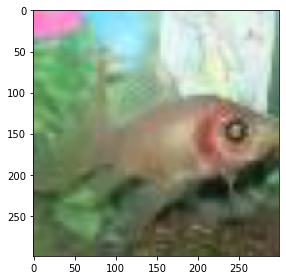

In [3]:
Xi = skimage.io.imread("n01443537_0.jpeg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [4]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

1/1 [==============================] - 2s 2s/step


[('n01440764', 'tench', 0.113631964),
 ('n02500267', 'indri', 0.09024706),
 ('n02490219', 'marmoset', 0.07076037),
 ('n02356798', 'fox_squirrel', 0.06719975),
 ('n01443537', 'goldfish', 0.05298547)]

In [5]:
top_pred_classes = preds[0].argsort()[-6:][::-1]
top_pred_classes

array([  0, 384, 377, 335,   1, 392], dtype=int64)

69


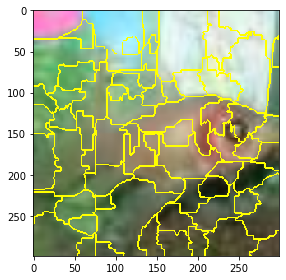

In [6]:
from skimage.segmentation import mark_boundaries
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
skimage.io.imshow(mark_boundaries(Xi/2+0.5,superpixels))
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)

In [7]:
num_perturb = 150

In [8]:
perturbations=[]
for i in range(150):
  perturbations.append(np.random.choice(2,num_superpixels,p=[0.4,0.6]))
perturbations

[array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1]),
 array([0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0]),
 array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1]),
 array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0]),
 array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1

In [9]:
perturbations[0]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1])

In [10]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

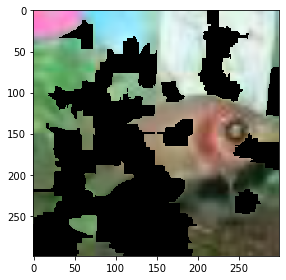

In [11]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [12]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions[0]

1/1 [==============================] - 0s 91ms/step


array([[1.54307578e-03, 3.51367071e-02, 5.81757573e-04, 5.90695476e-04,
        9.05667897e-04, 4.47777100e-03, 4.43362107e-04, 1.13709550e-03,
        9.29993286e-04, 3.91069450e-04, 4.30770451e-03, 4.39042598e-03,
        4.82546585e-03, 5.84159279e-04, 1.85314787e-03, 1.01371994e-03,
        1.98100926e-03, 1.68099580e-03, 5.18380373e-04, 8.84934911e-04,
        9.84856626e-04, 1.52169296e-03, 3.53764219e-04, 1.81749405e-03,
        1.87166239e-04, 4.50943335e-04, 4.66560712e-03, 2.88553303e-03,
        8.31517624e-04, 3.23496223e-03, 1.23848801e-03, 1.96907436e-03,
        2.27676425e-03, 1.55933504e-03, 4.37799725e-04, 2.72925623e-04,
        7.90651073e-04, 3.37368489e-04, 3.16484924e-03, 5.25850919e-04,
        1.10265415e-03, 8.34432431e-04, 1.38509378e-03, 1.35859929e-03,
        5.51619101e-04, 1.05792307e-04, 1.33826793e-03, 2.95192399e-03,
        1.87512313e-04, 2.21847498e-04, 7.10555702e-04, 1.36923641e-02,
        2.71355180e-04, 2.77163053e-04, 4.26979997e-04, 1.180525

In [13]:
active_block = np.unique(superpixels)
active_block

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68], dtype=int64)

In [14]:
def click_event(event, x, y, flags, params):
    x, y = y, x
    
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        # displaying the coordinates
        print(x, ' ', y, ' blook = ', superpixels[x, y], end='\r')
        
        if superpixels[x, y] in inactive_block:
            inactive_block.remove(superpixels[x, y])
        else:
            inactive_block.append(superpixels[x, y])
 
        active_pixels = list(set(active_block).difference(set(inactive_block)))
    
        mask = np.zeros(superpixels.shape)
        for active in active_pixels:
            mask[superpixels == active] = 1
            
        perturbed_image = copy.deepcopy(Xi)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        img = perturbed_image[:, :, ::-1]
        
        cv2.imshow('image', img)

In [15]:
# reading the image
img = Xi[:, :, ::-1]

# displaying the image
cv2.imshow('image', img)

inactive_block = []

# setting mouse handler for the image and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

inactive_block.sort()
print(inactive_block)

[28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 43]


In [16]:
array=np.array(inactive_block)

In [17]:
array.shape

(12,)

In [18]:
len(array)

12

In [19]:
predictions[0].shape

(1, 1000)

In [20]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances)

[0.24819059 0.19242715 0.18350342 0.19242715 0.22915443 0.25789176
 0.23861301 0.27768488 0.25789176 0.21057717 0.19242715 0.22915443
 0.28778769 0.20145059 0.23861301 0.27768488 0.25789176 0.22915443
 0.21057717 0.25789176 0.2198105  0.22915443 0.18350342 0.26772144
 0.29803588 0.24819059 0.23861301 0.23861301 0.30843593 0.2198105
 0.22915443 0.22915443 0.24819059 0.13188527 0.26772144 0.16594234
 0.25789176 0.24819059 0.21057717 0.2198105  0.18350342 0.14027305
 0.23861301 0.24819059 0.24819059 0.2198105  0.25789176 0.17467617
 0.22915443 0.17467617 0.27768488 0.18350342 0.21057717 0.20145059
 0.28778769 0.22915443 0.14027305 0.21057717 0.22915443 0.24819059
 0.22915443 0.20145059 0.25789176 0.2198105  0.18350342 0.21057717
 0.23861301 0.24819059 0.24819059 0.23861301 0.23861301 0.27768488
 0.27768488 0.24819059 0.15729903 0.24819059 0.22915443 0.21057717
 0.23861301 0.17467617 0.2198105  0.18350342 0.22915443 0.2198105
 0.28778769 0.2198105  0.18350342 0.18350342 0.23861301 0.257891

In [21]:
distances.shape

(150,)

In [22]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights)

[0.61092044 0.74361961 0.7638468  0.74361961 0.65698505 0.58739059
 0.63413757 0.53963022 0.58739059 0.7013544  0.74361961 0.65698505
 0.51552266 0.72277398 0.63413757 0.53963022 0.58739059 0.65698505
 0.7013544  0.58739059 0.67940813 0.65698505 0.7638468  0.56360695
 0.49134778 0.61092044 0.63413757 0.63413757 0.46717014 0.67940813
 0.65698505 0.65698505 0.61092044 0.87009769 0.56360695 0.80228218
 0.58739059 0.61092044 0.7013544  0.67940813 0.7638468  0.85435181
 0.63413757 0.61092044 0.61092044 0.67940813 0.58739059 0.78341389
 0.65698505 0.78341389 0.53963022 0.7638468  0.7013544  0.72277398
 0.51552266 0.65698505 0.85435181 0.7013544  0.65698505 0.61092044
 0.65698505 0.72277398 0.58739059 0.67940813 0.7638468  0.7013544
 0.63413757 0.61092044 0.61092044 0.63413757 0.63413757 0.53963022
 0.53963022 0.61092044 0.8204159  0.61092044 0.65698505 0.7013544
 0.63413757 0.78341389 0.67940813 0.7638468  0.65698505 0.67940813
 0.51552266 0.67940813 0.7638468  0.7638468  0.63413757 0.587390

In [23]:
weights.shape

(150,)

In [24]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
intercept =simpler_model.intercept_[0]

In [25]:
predictions[:,:,class_to_explain].shape

(150, 1)

In [26]:
print(coeff)

[ 1.07306600e-03 -1.94808462e-03  5.50990661e-04  2.31842791e-03
 -4.86530810e-03  3.50831891e-03 -1.60964748e-04  1.52596642e-03
  2.73255456e-03 -1.74317621e-04  2.02512537e-03 -1.57622494e-03
  1.74379531e-03  1.19673454e-03  2.20312753e-03  1.91232721e-03
  3.58440973e-04 -9.38282137e-05  4.32957064e-06  3.41677694e-03
 -1.04765396e-03  4.17361515e-03 -1.38041173e-03  8.68277504e-04
 -1.38062660e-03 -4.79261019e-04  4.01458771e-03  2.68155510e-03
  2.81574132e-03  4.02033461e-03 -3.21591088e-04  1.32820302e-03
 -1.51232534e-03  2.74572733e-03  3.37016838e-03 -4.14953330e-03
 -9.08249761e-04 -2.83149444e-04 -2.40709987e-04 -2.69529849e-04
 -9.14146070e-04  2.38745149e-03 -2.53366724e-03 -2.74496424e-03
  1.17497600e-03 -1.94081367e-04 -3.31308918e-03  3.76421821e-04
  1.05588309e-03  1.43356976e-03  1.54117110e-03 -8.46353315e-04
 -6.59415180e-04 -1.21880498e-03  3.67620630e-04  9.24579815e-04
 -2.13647794e-03  3.24418766e-03  2.71059958e-03 -5.22874902e-04
 -2.21952090e-03 -7.16779

In [27]:
predictions[:,:,class_to_explain]

array([[1.54307578e-03],
       [2.27560080e-03],
       [1.26411353e-04],
       [2.98752013e-04],
       [7.78428948e-05],
       [1.11114644e-01],
       [2.32006743e-04],
       [5.44902752e-04],
       [2.68251752e-04],
       [6.17635087e-04],
       [4.11546906e-04],
       [4.55299625e-04],
       [2.79848697e-04],
       [3.09949508e-04],
       [4.01604408e-03],
       [3.38663958e-04],
       [9.24449693e-03],
       [9.18458609e-05],
       [1.90024162e-04],
       [4.76428948e-04],
       [1.34912101e-04],
       [8.68826930e-04],
       [1.45034399e-02],
       [1.68472267e-04],
       [1.44334437e-04],
       [1.28333764e-02],
       [1.67071226e-03],
       [2.51382415e-04],
       [9.17293582e-05],
       [2.50667508e-04],
       [2.42281691e-04],
       [7.81924638e-04],
       [6.00667787e-04],
       [2.95666140e-03],
       [1.26165675e-03],
       [2.98161322e-04],
       [4.10907576e-03],
       [1.96809589e-04],
       [1.18474313e-03],
       [3.16930440e-04],


In [28]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

regr_rf=RandomForestRegressor()
regr_rf.fit(X=perturbations, y=predictions[:,:,class_to_explain],sample_weight=weights)

RandomForestRegressor()

In [29]:
y_pred=regr_rf.predict(perturbations)

In [30]:
y_pred

array([0.00550386, 0.00287408, 0.00074271, 0.00056237, 0.00059982,
       0.07090901, 0.00504079, 0.00331533, 0.00165756, 0.00197263,
       0.00105302, 0.00912401, 0.00239135, 0.00085797, 0.00781057,
       0.00843004, 0.00727842, 0.00122652, 0.00254259, 0.00686791,
       0.0005025 , 0.0051408 , 0.0112702 , 0.00679729, 0.00282892,
       0.01089362, 0.00745221, 0.0082471 , 0.0039423 , 0.00183489,
       0.00055641, 0.00169685, 0.00467475, 0.0051489 , 0.00558402,
       0.00136892, 0.00966962, 0.00286647, 0.00401887, 0.00231838,
       0.0012059 , 0.01099681, 0.00215639, 0.00540974, 0.00529822,
       0.00295229, 0.00231936, 0.00178666, 0.00323455, 0.0094177 ,
       0.00434244, 0.00249605, 0.00360522, 0.0005414 , 0.00289477,
       0.00201744, 0.00212239, 0.00086046, 0.00236994, 0.00236999,
       0.00252452, 0.00204786, 0.00061062, 0.00151895, 0.0015126 ,
       0.00439982, 0.00666218, 0.0036052 , 0.00689475, 0.00571153,
       0.00202934, 0.00202361, 0.00236056, 0.00156679, 0.00092

In [31]:
importances = regr_rf.feature_importances_

In [32]:
importances

array([0.02743584, 0.00906725, 0.00662667, 0.00685213, 0.02828678,
       0.00629402, 0.00666522, 0.01419313, 0.00385459, 0.00171815,
       0.01281993, 0.01328706, 0.00995588, 0.00520457, 0.00893859,
       0.00354109, 0.01746227, 0.01614338, 0.00922165, 0.00089527,
       0.02054895, 0.00580784, 0.00741266, 0.00282977, 0.00884667,
       0.01976088, 0.01600395, 0.00874175, 0.01582667, 0.01008544,
       0.0436298 , 0.00178092, 0.01862954, 0.00656709, 0.0117155 ,
       0.00745313, 0.01697627, 0.0375863 , 0.01919161, 0.00567116,
       0.01823846, 0.00503239, 0.03693252, 0.02525442, 0.00699515,
       0.0211385 , 0.04888121, 0.01238257, 0.00273504, 0.01328151,
       0.00835649, 0.01873534, 0.01479544, 0.00996677, 0.0046255 ,
       0.01310027, 0.02659861, 0.0057639 , 0.00962435, 0.01304447,
       0.02243585, 0.01067883, 0.00623203, 0.00894901, 0.04386421,
       0.03567626, 0.02827471, 0.0279304 , 0.00694642])

In [33]:
importances.shape

(69,)

In [34]:
num_top_features = len(array)
top_features2 = np.argsort(importances)[-num_top_features:] 
top_features2

array([43, 56,  0, 67, 66,  4, 65, 42, 37, 30, 64, 46], dtype=int64)

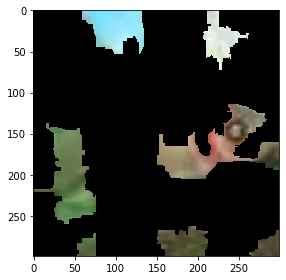

In [35]:
mask = np.zeros(num_superpixels) 
mask[top_features2]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [36]:
intercept=simpler_model.intercept_[0]
intercept

-0.006271055258895153

In [37]:
coeff.shape

(69,)

In [38]:
num_top_features = len(array)
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([27, 58,  8, 33, 28, 57, 34, 19,  5, 26, 29, 21], dtype=int64)

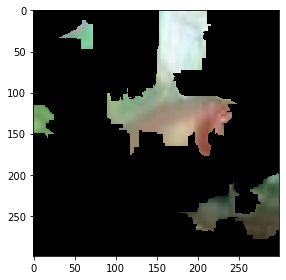

In [39]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [40]:
rfTrue=(len(set(array) & set(top_features2))/len(array))

In [41]:
print(rfTrue)

0.25


In [42]:
limeTrue=(len(set(array) & set(top_features))/len(array))

In [43]:
print(limeTrue)

0.3333333333333333


In [44]:
from sklearn import tree

In [45]:
treemodel=tree.DecisionTreeRegressor(max_depth=5)
treemodel.fit(perturbations,predictions[:,:,class_to_explain],sample_weight=weights)

DecisionTreeRegressor(max_depth=5)

In [46]:
importances = treemodel.feature_importances_

In [47]:
importances

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.10680669e-05,
       0.00000000e+00, 4.20744437e-04, 1.08090311e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11219578e-03,
       0.00000000e+00, 2.64411979e-04, 0.00000000e+00, 0.00000000e+00,
       5.13531931e-06, 0.00000000e+00, 1.10458309e-04, 0.00000000e+00,
       1.83411818e-04, 0.00000000e+00, 0.00000000e+00, 5.23064057e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.19388834e-05,
       4.11512542e-02, 0.00000000e+00, 1.49452824e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.73383124e-07,
       0.00000000e+00, 0.00000000e+00, 4.60780231e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.20306849e-02, 4.64158908e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.20610334e-05, 8.60132129e-03,
      

In [48]:
importances.shape

(69,)

In [49]:
num_top_features = len(array)
top_features3 = np.argsort(coeff)[-num_top_features:] 
top_features3

array([27, 58,  8, 33, 28, 57, 34, 19,  5, 26, 29, 21], dtype=int64)

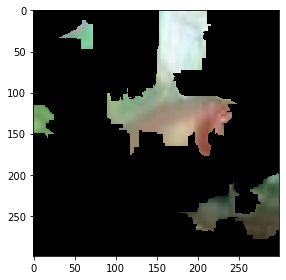

In [50]:
mask = np.zeros(num_superpixels) 
mask[top_features3]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [51]:
TreeTrue=(len(set(array) & set(top_features3))/len(array))

In [52]:
print(TreeTrue)

0.3333333333333333


In [53]:
import xgboost as xgb

xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(perturbations,predictions[:,:,class_to_explain],sample_weight=weights)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [54]:
importances=xgbrModel.feature_importances_

In [55]:
importances

array([0.0044663 , 0.07451335, 0.00057022, 0.01213213, 0.01872352,
       0.01065889, 0.01727882, 0.07285117, 0.00219237, 0.00159424,
       0.00197626, 0.02365504, 0.00552024, 0.00237304, 0.00201794,
       0.00093791, 0.00331088, 0.01081245, 0.00255326, 0.0225707 ,
       0.00162166, 0.01154418, 0.00369314, 0.00325082, 0.00116892,
       0.00658363, 0.10644946, 0.0024367 , 0.01515623, 0.02816506,
       0.0023561 , 0.00246056, 0.01051698, 0.00496807, 0.00725274,
       0.01256618, 0.00144364, 0.002953  , 0.00493807, 0.00177582,
       0.04621315, 0.00742692, 0.0393605 , 0.01100146, 0.00246083,
       0.00287794, 0.02939907, 0.00052741, 0.00464245, 0.00275584,
       0.0091493 , 0.00245768, 0.00064879, 0.02412683, 0.00062727,
       0.0004968 , 0.07174249, 0.00034636, 0.15234578, 0.00561065,
       0.00310476, 0.00047568, 0.00030317, 0.0013519 , 0.00906511,
       0.02521864, 0.        , 0.02382428, 0.00042926], dtype=float32)

In [56]:
importances.shape

(69,)

In [57]:
num_top_features = len(array)
top_features4 = np.argsort(coeff)[-num_top_features:] 
top_features4

array([27, 58,  8, 33, 28, 57, 34, 19,  5, 26, 29, 21], dtype=int64)

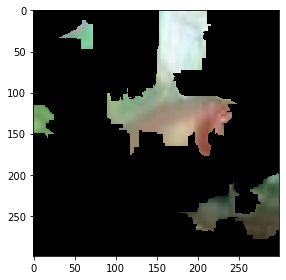

In [58]:
mask = np.zeros(num_superpixels) 
mask[top_features4]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [59]:
xgbstTrue=(len(set(array) & set(top_features4))/len(array))

In [60]:
print(xgbstTrue)

0.3333333333333333
